<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [203]:
import itertools
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.ticker as ticker
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import jaccard_score, accuracy_score, f1_score, log_loss, confusion_matrix, precision_score,classification_report
%matplotlib inline

In [204]:
#notice: Disable all warnings 
import warnings
warnings.filterwarnings('ignore')

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [205]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2022-09-21 14:09:53--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2022-09-21 14:09:53 (71.0 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [206]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [207]:
df.shape

(346, 10)

### Convert to date time object


In [208]:
def to_datetime(df):
    df['due_date'] = pd.to_datetime(df['due_date'])
    df['effective_date'] = pd.to_datetime(df['effective_date'])
    return df.head()
    
to_datetime(df)

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [209]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [210]:
# notice: installing seaborn might takes a few minutes
!pip install seaborn

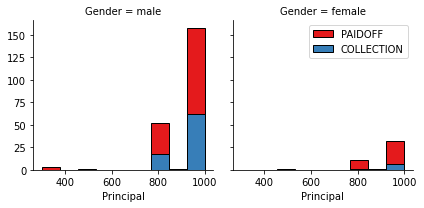

In [211]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

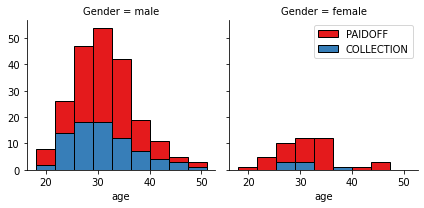

In [212]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


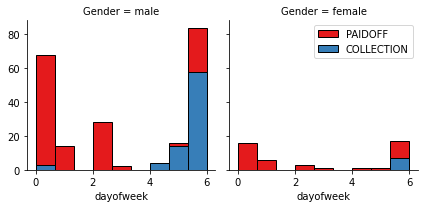

In [213]:

def week(df):
    df['dayofweek'] = df['effective_date'].dt.dayofweek
    bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
    g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
    g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
    g.axes[-1].legend()
    plt.show()
    df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)    
    
week(df)


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [214]:
# df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [215]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [216]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [217]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [218]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [219]:
def encode(data):
    Feature = data[['Principal','terms','age','Gender','weekend']]
    Feature = pd.concat([Feature,pd.get_dummies(data['education'])], axis=1)
    Feature.drop(['Master or Above'], axis = 1,inplace=True)
    target_ = data[['loan_status']].replace(['PAIDOFF','COLLECTION'], [1,0])
    return Feature, target_

Feature, y=encode(df)

### Feature Selection


Let's define feature sets, X:


In [220]:
X = Feature
X[0:5]
X

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1
...,...,...,...,...,...,...,...,...
341,800,15,32,0,1,0,1,0
342,1000,30,25,0,1,0,1,0
343,800,15,39,0,0,0,0,1
344,1000,30,28,0,0,0,0,1


What are our lables?


In [221]:
# y = df[['loan_status']].replace(['PAIDOFF','COLLECTION'], [1,0])


## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [222]:
# X= preprocessing.StandardScaler().fit(X).transform(X)
# X[0:5]
scaler=preprocessing.StandardScaler()
X=pd.DataFrame(scaler.fit_transform(X), columns=Feature.columns)
X


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,0.515785,0.920718,2.331526,-0.420560,-1.205778,-0.381701,1.136394,-0.869681
1,0.515785,0.920718,0.341701,2.377782,-1.205778,2.619854,-0.879977,-0.869681
2,0.515785,-0.959111,-0.653211,-0.420560,-1.205778,-0.381701,-0.879977,1.149847
3,0.515785,0.920718,-0.487392,2.377782,0.829340,-0.381701,-0.879977,1.149847
4,0.515785,0.920718,-0.321573,-0.420560,0.829340,-0.381701,-0.879977,1.149847
...,...,...,...,...,...,...,...,...
341,-1.314589,-0.959111,0.175883,-0.420560,0.829340,-0.381701,1.136394,-0.869681
342,0.515785,0.920718,-0.984848,-0.420560,0.829340,-0.381701,1.136394,-0.869681
343,-1.314589,-0.959111,1.336614,-0.420560,-1.205778,-0.381701,-0.879977,1.149847
344,0.515785,0.920718,-0.487392,-0.420560,-1.205778,-0.381701,-0.879977,1.149847


# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


## train test split

In [223]:
x_train, x_test, y_train, y_test=train_test_split(X, y,test_size=0.2, random_state=42)

In [224]:
def KNN(n, xtrain, xtest, ytrain):
    knn=KNeighborsClassifier(n_neighbors=n, weights='uniform', algorithm='auto', leaf_size=30, 
                        p=2, metric='minkowski', metric_params=None, n_jobs=None)
    knn.fit(xtrain, ytrain)
    kpred=knn.predict(xtest)

    return knn, kpred

In [225]:
def best_K(xtrain, ytrain, xtest, ytest):
    global rmse
    rmse=[]
    for i in range(1, 15):
        knn_obj, kpred_value=KNN(i,xtrain,xtest,ytrain)
        mse_knn_model3=mean_squared_error(ytest, kpred_value)
        rmse.append(mse_knn_model3)

        print("At k=", i,"\nTrain score =", accuracy_score(ytrain,knn_obj.predict(xtrain)), end='')
        print(" | Test Score =", accuracy_score(ytest,kpred_value), end='')
        print(" | MSE:", mse_knn_model3)
        print()

In [226]:
best_K(x_train, y_train,x_test, y_test)

At k= 1 
Train score = 0.8695652173913043 | Test Score = 0.6857142857142857 | MSE: 0.3142857142857143

At k= 2 
Train score = 0.8152173913043478 | Test Score = 0.6142857142857143 | MSE: 0.38571428571428573

At k= 3 
Train score = 0.8297101449275363 | Test Score = 0.7857142857142857 | MSE: 0.21428571428571427

At k= 4 
Train score = 0.8152173913043478 | Test Score = 0.6714285714285714 | MSE: 0.32857142857142857

At k= 5 
Train score = 0.8043478260869565 | Test Score = 0.7571428571428571 | MSE: 0.24285714285714285

At k= 6 
Train score = 0.7898550724637681 | Test Score = 0.7285714285714285 | MSE: 0.2714285714285714

At k= 7 
Train score = 0.8079710144927537 | Test Score = 0.7571428571428571 | MSE: 0.24285714285714285

At k= 8 
Train score = 0.7971014492753623 | Test Score = 0.6571428571428571 | MSE: 0.34285714285714286

At k= 9 
Train score = 0.8007246376811594 | Test Score = 0.7428571428571429 | MSE: 0.2571428571428571

At k= 10 
Train score = 0.7898550724637681 | Test Score = 0.7285714

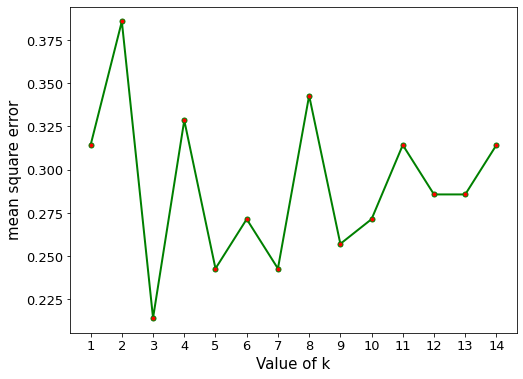

In [227]:
def plot_k():
    x=np.arange(1,15)
    plt.figure(figsize=(8,6))
    plt.plot(x, rmse,  color='green', linewidth = 2, marker='o', markerfacecolor='red', markersize=5)
    plt.xticks(np.arange(min(x), max(x)+1, 1.0))
    plt.xlabel("Value of k", fontsize=15)
    plt.ylabel("mean square error",fontsize=15)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
plot_k()

### optimum value of k is 3

In [228]:
knn_obj,kpred=KNN(3,x_train, x_test, y_train)
print("KNN jaccard score: ", jaccard_score(y_test, kpred))
print("KNN f1_score: ", f1_score(y_test, kpred))
print("KNN test accuracy-score: ", accuracy_score(y_test, kpred))
print(confusion_matrix(y_test, kpred))
print(print(classification_report(y_test, kpred)))

KNN jaccard score:  0.765625
KNN f1_score:  0.8672566371681416
KNN test accuracy-score:  0.7857142857142857
[[ 6  8]
 [ 7 49]]
              precision    recall  f1-score   support

           0       0.46      0.43      0.44        14
           1       0.86      0.88      0.87        56

    accuracy                           0.79        70
   macro avg       0.66      0.65      0.66        70
weighted avg       0.78      0.79      0.78        70

None


# Decision Tree


In [229]:
dt = DecisionTreeClassifier(criterion="gini", max_depth=4)
dt.fit(x_train, y_train)
dt_pred=dt.predict(x_test)
print("train accuracy:",accuracy_score(y_train,dt.predict(x_train)))
print("test accuracy:",accuracy_score(y_test,dt_pred))
print("f1_score:",f1_score(y_test,dt_pred))
print("jaccard score: ", jaccard_score(y_test, dt_pred))


train accuracy: 0.7644927536231884
test accuracy: 0.7
f1_score: 0.8108108108108109
jaccard score:  0.6818181818181818


# Support Vector Machine


In [230]:
svm=SVC(kernel='rbf')
svm.fit(x_train, y_train)
print("train acurracy: ", accuracy_score(y_train, svm.predict(x_train)))
print("test acurracy: ", accuracy_score(y_test, svm.predict(x_test)))
print('f1_score:', f1_score(y_test, svm.predict(x_test),average='weighted'))
print(" jaccard score: ", jaccard_score(y_test, svm.predict(x_test)))
print(confusion_matrix(y_test, svm.predict(x_test)))


train acurracy:  0.7789855072463768
test acurracy:  0.6857142857142857
f1_score: 0.6763832658569502
 jaccard score:  0.6764705882352942
[[ 2 12]
 [10 46]]


# Logistic Regression


In [231]:
LR = LogisticRegression(solver='liblinear').fit(x_train,y_train)
LR_pred=LR.predict(x_test)
print("F1 score", f1_score(y_test,LR_pred))
print("test accuracy score", accuracy_score(y_test,LR_pred))
print("train accuracy score", accuracy_score(y_train,LR.predict(x_train)))
print("jaccard index", jaccard_score(y_test,LR_pred))
print("log loss", log_loss(y_test,LR_pred))
print("confusion_matrix:\n ", confusion_matrix(y_test, LR_pred))

F1 score 0.8141592920353982
test accuracy score 0.7
train accuracy score 0.7681159420289855
jaccard index 0.6865671641791045
log loss 10.361758569497951
confusion_matrix:
  [[ 3 11]
 [10 46]]


# Model Evaluation using Test set


In [232]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [233]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2022-09-21 14:10:00--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2022-09-21 14:10:01 (27.5 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [234]:
test_df = pd.read_csv('loan_test.csv')


In [235]:
to_datetime(test_df)

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


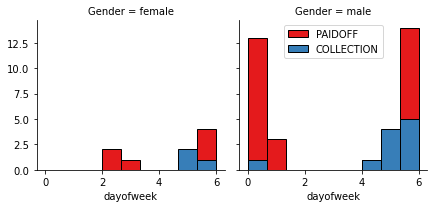

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6,1


In [236]:
week(test_df)
test_df.head()

In [237]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [238]:
test_features, target=encode(test_df)

## normalized

In [239]:
scaler=preprocessing.StandardScaler()
x_normalized=pd.DataFrame(scaler.fit_transform(test_features), columns=test_features.columns)


## knn

In [240]:
knn=KNeighborsClassifier(n_neighbors=9, weights='uniform', algorithm='auto', leaf_size=30, 
                        p=2, metric='minkowski', metric_params=None, n_jobs=None)
knn.fit(X,y)
predicted_values=knn.predict(x_normalized)
print("F1 score ",f1_score(target, predicted_values))
print("jaccard index ",jaccard_score(target, predicted_values))


F1 score  0.8045977011494252
jaccard index  0.6730769230769231


## Decision Tree

In [241]:
dt = DecisionTreeClassifier(criterion="gini", max_depth=4)
dt.fit(X, y)
dt_pred_=dt.predict(x_normalized)

print("f1_score:",f1_score(target,dt_pred_))
print("jaccard score: ", jaccard_score(target, dt_pred_))


f1_score: 0.8666666666666667
jaccard score:  0.7647058823529411


## logistic regression

In [242]:
LR = LogisticRegression(solver='liblinear').fit(X,y)
LR_pred_=LR.predict(x_normalized)
print("F1 score", f1_score(target,LR_pred_))
print("jaccard index", jaccard_score(target,LR_pred_))
print("log loss", log_loss(target,LR_pred_))


F1 score 0.8602150537634409
jaccard index 0.7547169811320755
log loss 8.315083109267249


## SVM

In [243]:
svm_=SVC(kernel='rbf')
svm_.fit(X, y)
svm_pred=svm.predict(x_normalized)
print('f1_score:', f1_score(target, svm_pred,average='weighted'))
print(" jaccard score: ", jaccard_score(target, svm_pred))


f1_score: 0.7288207747977863
 jaccard score:  0.74


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
